In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/HokuMaker/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycm livelossplot torchinfo torchvision
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchvision
from torchvision import transforms

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
import glob
from PIL import Image

tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Get all image file paths
image_paths = glob.glob('/content/drive/MyDrive/HokuMaker/Katsushika_Hokusai/*.jpg')  # or *.png, *.jpeg, etc.

# Create dataset manually
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


dataset = CustomImageDataset(image_paths, transform=tf)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)



In [ ]:
print(len(dataset))

141


In [ ]:
print(next(iter(dataloader))[0].shape)
print(next(iter(dataloader))[0].max())
print(next(iter(dataloader))[0].min())

torch.Size([3, 256, 256])
tensor(1.)
tensor(-0.7176)


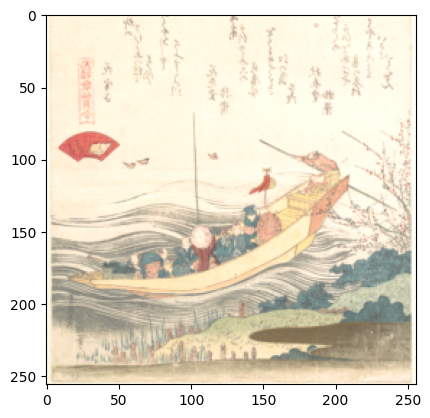

In [ ]:
plt.imshow((np.transpose(next(iter(dataloader))[0], (1, 2, 0))+1)/2)

In [ ]:
def arrange(x):
  return (np.transpose(x.cpu(), (1, 2, 0))+1)/2

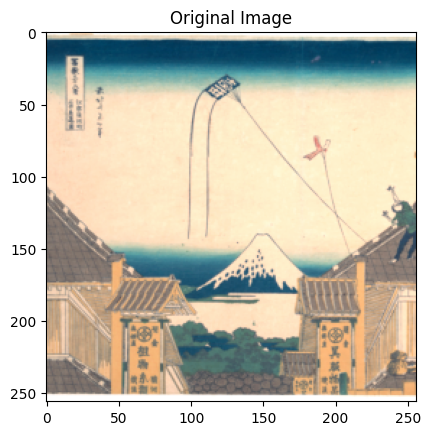

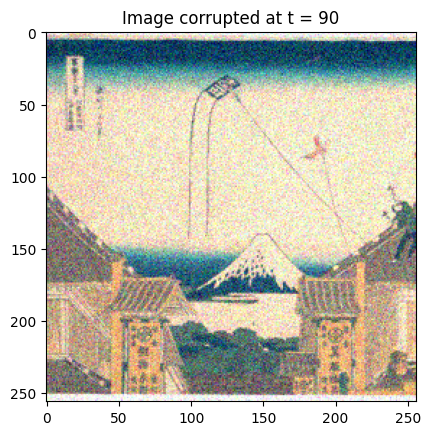

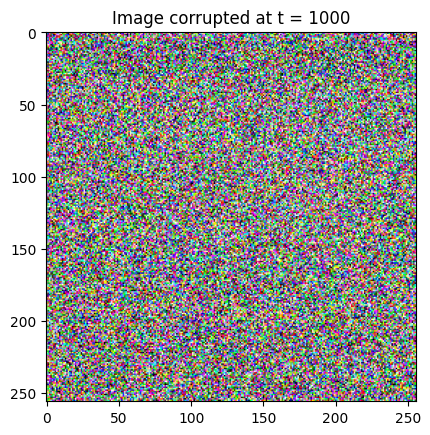

tensor(4.9230, device='cuda:0')
tensor(-4.2467, device='cuda:0')


In [ ]:
# Number of variance timesteps
T = 1000

# Define a linear variance schedule
beta_1 = 5e-5
beta_T = 0.01
betas = torch.linspace(beta_1, beta_T, T) # These are the noise variances added to the sample for every t in [0, T]

betas.shape

# Pre-calculate other helpful terms that derive from the variance schedule
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, axis=0)

alphas.shape, alphas_bar.shape

x = next(iter(dataloader))[0]
x = x.to(device)
t = 90
e = torch.randn_like(x)

# Forward process
xt = torch.sqrt(alphas_bar[t]) * x + torch.sqrt(1 - alphas_bar[t]) * e

# Plots
plt.imshow(arrange(x))
plt.title(f'Original Image')
plt.show()

plt.imshow(arrange(xt))
plt.title(f'Image corrupted at t = {90}')
plt.show()

xt = torch.sqrt(alphas_bar[T-1]) * x + torch.sqrt(1 - alphas_bar[T-1]) * e

plt.imshow(arrange(xt))
# add title
plt.title(f'Image corrupted at t = {T}')
plt.show()
print(xt.max())
print(xt.min())

In [ ]:
# for a batch of timesteps t, and expands its dimensionality to that of the data
def fix_batch(sched, t, device):
    """extract sched at time t, and expand to batch dimensionality"""
    return sched.to(device)[t.to(device)].view(-1, 1, 1, 1)

# Each sample from the batch will have a different level of noise perturbation so that
# the network does not memorise any individual

# Let's check and understand these dimensions:
t = torch.randint(0, T, (32,))
print(alphas.shape, t.shape, fix_batch(alphas, t, device).shape)

def forward_diffusion(x0, t, e):
    """run the forward diffusion process on x up to time t using noise e"""
    sqrt_alphas = fix_batch(torch.sqrt(alphas_bar), t, x0.device)
    sqrt_alphas_minus_one = fix_batch(torch.sqrt(1. - alphas_bar), t, x0.device)

    return sqrt_alphas*x0 + sqrt_alphas_minus_one*e

torch.Size([1000]) torch.Size([32]) torch.Size([32, 1, 1, 1])


In [ ]:
# Define the sinusoidal position embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    """sinusoidal position embedding, https://arxiv.org/abs/1706.03762"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # Given a batch of timesteps, create a batch of representative vectors
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
# Define a convolutional block with time-embedding
class ConvBlock(nn.Module):
    """time-conditioned convolutional block"""

    def __init__(self, in_c, out_c, embed_dim, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.dense = nn.Linear(embed_dim, out_c) # reshapes the time embedding length to the number of channels
        self.bn = nn.GroupNorm(8, out_c)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x, t_embed):
        x = self.conv(x)
        x += self.dense(t_embed)[...,None,None] # add the output of the time embedding dense layer
        x = self.bn(x)
        x = self.act(x)
        if self.training:  # Only apply dropout during training
            x = self.dropout(x)
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):
    """time-conditioned U-Net encoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x, t_embed):
        h = self.conv_block1(x, t_embed)
        h = self.conv_block2(h, t_embed)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):
    """time-conditioned U-Net decoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)

    def forward(self, x, s, t_embed):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h, t_embed)
        h = self.conv_block2(h, t_embed)
        return h

In [ ]:
class Unet(nn.Module):
    """DDPM U-Net, https://arxiv.org/abs/2006.11239 and https://arxiv.org/abs/1505.04597"""

    def __init__(self, n_channels, embed_dim):
        super().__init__()

        # time positional embedding MLP
        self.embed = nn.Sequential(SinusoidalPositionEmbeddings(embed_dim),
                                   nn.Linear(embed_dim, embed_dim),
                                   nn.GELU(),
                                   nn.Linear(embed_dim, embed_dim))

        # encoder
        self.e1 = EncBlock(n_channels, 64, embed_dim)
        self.e2 = EncBlock(64, 128, embed_dim)
        self.e3 = EncBlock(128, 256, embed_dim)
        self.e4 = EncBlock(256, 512, embed_dim)

        # bottleneck
        self.b1 = ConvBlock(512, 1024, embed_dim)
        self.b2 = ConvBlock(1024, 1024, embed_dim)

        # decoder
        self.d1 = DecBlock(1024, 512, embed_dim)
        self.d2 = DecBlock(512, 256, embed_dim)
        self.d3 = DecBlock(256, 128, embed_dim)
        self.d4 = DecBlock(128, 64, embed_dim)
        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x, t):

        t_embed = self.embed(t)

        # encoder
        s1, x = self.e1(x, t_embed)
        s2, x = self.e2(x, t_embed)
        s3, x = self.e3(x, t_embed)
        s4, x = self.e4(x, t_embed)

        # bottleneck
        x = self.b1(x, t_embed)
        x = self.b2(x, t_embed)

        # decoder
        x = self.d1(x, s4, t_embed)
        x = self.d2(x, s3, t_embed)
        x = self.d3(x, s2, t_embed)
        x = self.d4(x, s1, t_embed)

        # output
        output = self.output(x)

        return output

In [ ]:
# define the model and send to the GPU
model = Unet(3, 128).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser,
    T_max=n_epoch * len(dataloader),  # Total training steps
    eta_min=1e-6  # Minimum LR
)
criterion = F.mse_loss

In [ ]:
model.train()

# Set number of epochs and loop over them
n_epoch = 50
for epoch in range(n_epoch):

    # Loop over each batch using tqdm to report progress and loss stats
    # Note that here we're denoting the uncorrupted batch as x0 and that
    # we once again do not care for their labels
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epoch}", leave=False)
    for x0 in pbar:

        optimiser.zero_grad()

        x0 = x0.to(device)

        # Sample t from a uniform distribution
        t = torch.randint(0, T, (x0.shape[0],), dtype=torch.long).to(x0.device)

        # Sample e from a normal distribution
        e = torch.randn_like(x0)

        # Run the forward diffusion process to add noise to x0
        # The corrupted batch (at various levels of noise) is denoted as xt
        xt = forward_diffusion(x0, t, e)

        # Calculate the loss between the predicted noise and the true noise
        loss = criterion(model(xt, t), e)

        # Backpropagation to obtain gradients w.r.t model parameters
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Report current loss using tqdm
        pbar.set_description(f"loss: {loss.item():.4f}")

        # Take an optimisation step
        optimiser.step()
        scheduler.step()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/HokuMaker/second_model.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/HokuMaker/second_model.pt'))

<All keys matched successfully>

In [ ]:
def reverse_diffusion(x, t, e, z):
    """run the reverse diffusion process"""
    sigma = fix_batch(torch.sqrt(betas), t, x.device)
    sqrt_recip_alphas = fix_batch(torch.sqrt(1.0 / alphas), t, x.device)
    scale = fix_batch((1 - alphas) / torch.sqrt(1. - alphas_bar), t, x.device)
    return sqrt_recip_alphas * (x - scale*e) + sigma*z

In [ ]:
# x = torch.randn_like(next(iter(dataloader)))
# print(x.shape)
x = torch.randn(1, 3, 256, 256)

In [ ]:
print(x.max())

tensor(4.5486)


t: 999


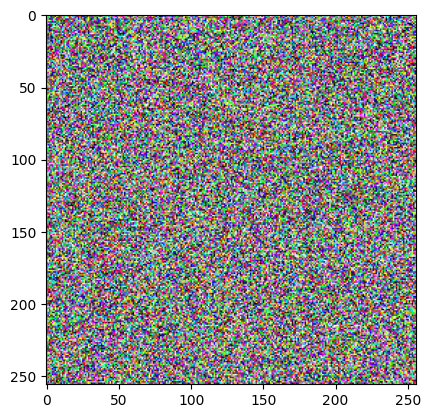

t: 900


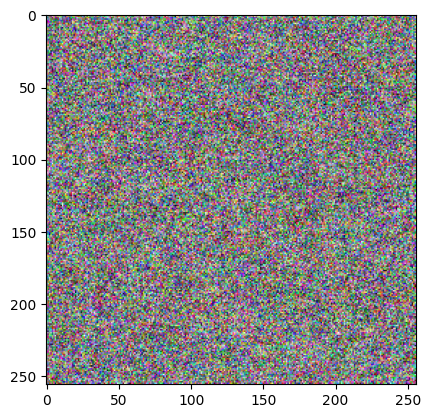

t: 800


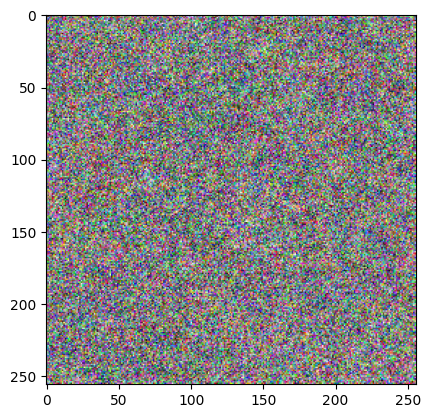

t: 700


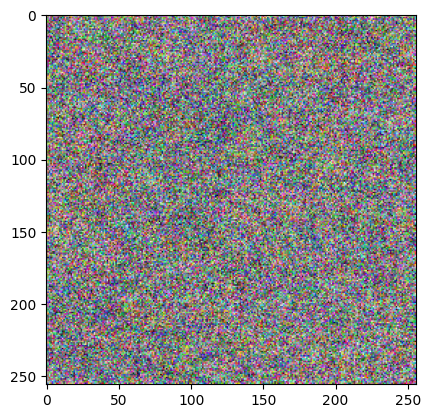

t: 600


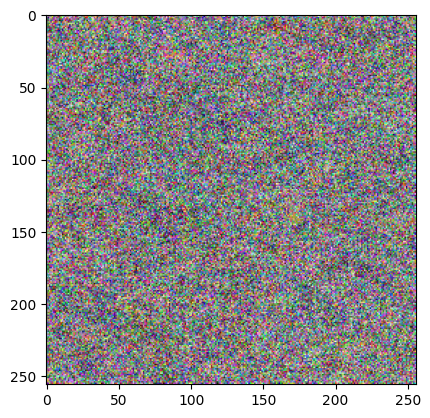

t: 500


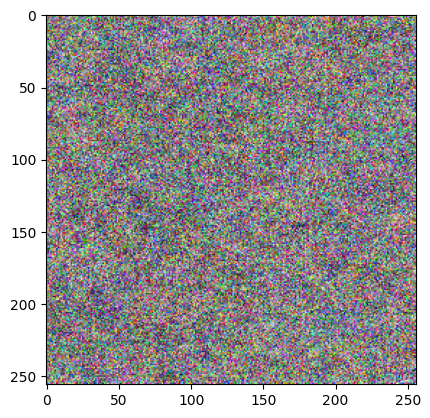

t: 400


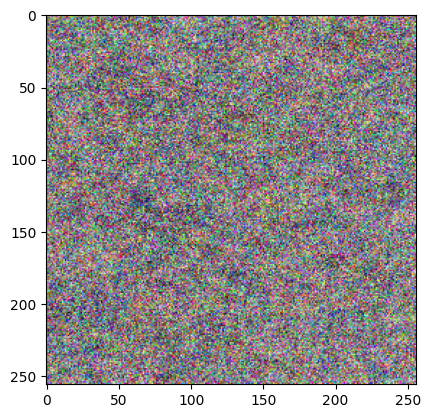

t: 300


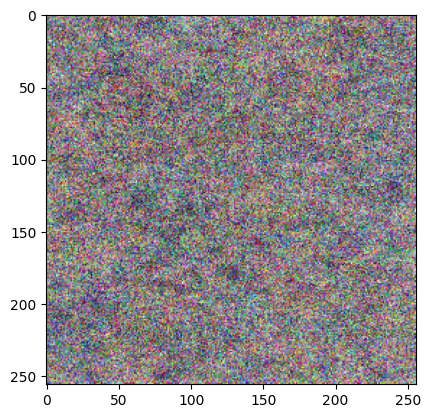

t: 200


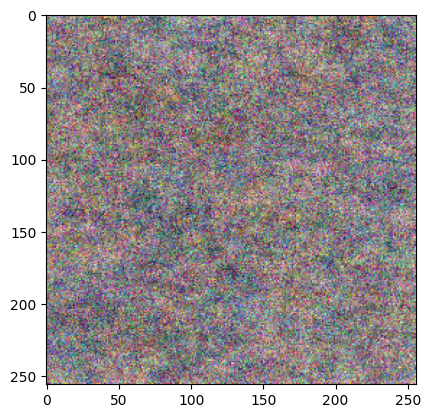

t: 100


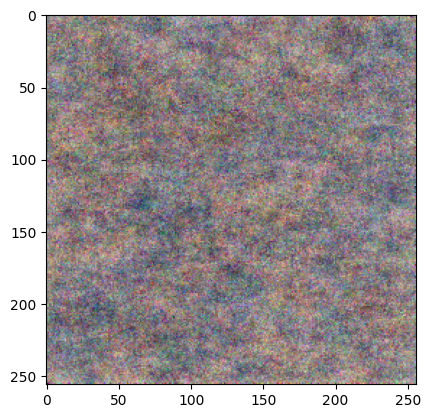

t: 0


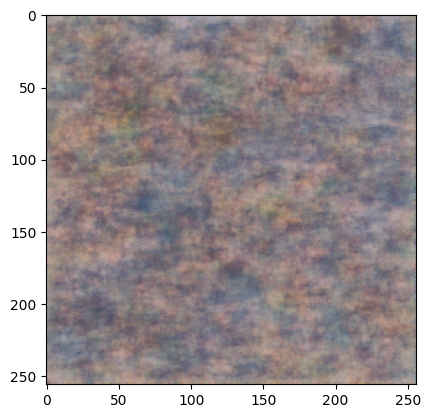

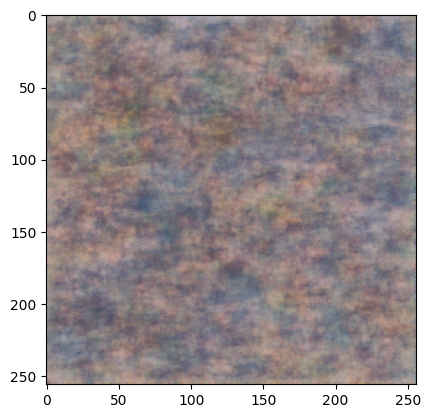

In [ ]:
# ensure model is in evaluation mode
model.eval()

# Randomly sample an xT batch from a normal distribution
# We will simply refer to xT as x
# send to the GPU and only consider first 16 of the batch to ease the computational burden
x = x.to(device)

# Container to store sample throughout the reverse diffusion
final = torch.empty_like(x).to(x.device)

# Context management to ensure gradients are not tracked for any torch tensors or parameters
# since we are only interested in sampling, not training
with torch.no_grad():

    # Loop over time from T to 0
    for t in reversed(range(0,T)):

        # sample z from a normal distribution if condition met
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0

        t_tensor = torch.full((x.shape[0],), t, dtype=torch.long, device=device)
        # denoise x
        res = model(x, t_tensor)
        x = reverse_diffusion(x, t_tensor, res, z)

        # clipping to ensure the sample values remain in the range -1 to 1
        x = torch.clamp(x, -1, 1)
        # print(x.max())

        # visualize every 100 iterations
        if t % 100 == 0 or t == 999:
            print(f"t: {t}")
            plt.imshow((x[0].permute(1, 2, 0).cpu().numpy()+1)/2)
            plt.show()

# visualize the final sample
plt.imshow((x[0].permute(1, 2, 0).cpu().numpy()+1)/2)
plt.show()

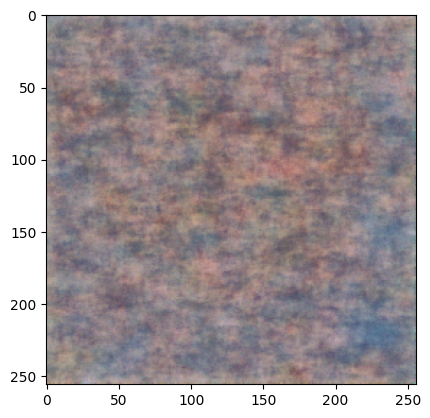

In [ ]:
plt.imshow((x[3].permute(1, 2, 0).cpu().numpy()+1)/2)
plt.show()
